# Sistema de Vectorización Geoquímica y Generación de Blancos (Target Generation)
Autor: Pablo Toledo Fecha: 01/12/2025

---

1. **El Por Qué**

En la exploración brownfield de sistemas IOCG (Iron Oxide Copper Gold) como Mantoverde o Candelaria, el descubrimiento de nuevos cuerpos mineralizados es complejo debido a la cobertura post-mineral y la sutileza de los halos geoquímicos distales. El objetivo de este proyecto es optimizar el presupuesto de perforación mediante la vectorización automática. Se busca identificar patrones en datos de superficie que indiquen la proximidad de un núcleo mineralizado, incluso cuando las leyes de cobre en superficie son bajas o marginales.

2. **El Cómo**

Se implementó un flujo de trabajo de Machine Learning para clasificar dominios geoquímicos y predecir proximidad al blanco, validado con modelos de zonación de IOCGs globales (Skirrow et al., 2002).

**Flujo de Trabajo:**

* **Geoquímica Vectorial**: Simulación de halos de dispersión utilizando elementos traza y ratios de alteración clave para la navegación:

* Vector Proximal: K/Na (Alteración Potásica vs. Sódica).

* Vector Distal: Mn y Zn (Halo Propilítico/Epitermal de baja temperatura).

* Vector Geofísico: Susceptibilidad Magnética (Magnetita en el núcleo).

Clustering (K-Means): Algoritmo de agrupamiento no supervisado para definir automáticamente zonas de Alta Prospectividad (Targets) basándose en la huella multielemental completa, permitiendo detectar anomalías sutiles que escapan al análisis univariable tradicional.

3. **El Resultado**

La herramienta genera un Mapa de Prospectividad que permite al equipo de exploración:

* Priorizar Targets: Identificar zonas de alta probabilidad ("Hotspots") para posicionar los sondajes.

* Validar Vectores: Confirmar visualmente la zonación desde la periferia (Mn-Zn) hacia el centro (Cu-Au-Fe).

* Reducir Riesgo: Evitar perforar en zonas de "Roca Caja" o halos distales estériles, aumentando la tasa de éxito del descubrimiento.

---
**Referencias Principales:**
* Capstone Copper (2024). Mantoverde Mine NI 43-101 Technical Report.

* Skirrow, R.G. et al. (2002). Chemical and mineralogical vectors to IOCG deposits. Geoscience Australia.

* Cloutier, J. et al. (2025). Hybrid data-driven approaches for IOCG potential mapping. Ore Geology Reviews.

* Rieger, A. et al. (2010). The Mantoverde Iron Oxide–Copper–Gold District. Economic Geology.

*  Se utilizaron asistentes de IA para acelerar la escritura de código Python, permitiendo enfocar el esfuerzo en el análisis de datos, la interpretación geológica y la validación.



In [ ]:
##_0_LIBRERÍAS Y CONFIGURACIÓN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

np.random.seed(42)
sns.set_theme(style="darkgrid", palette="viridis")

In [1]:
##_1_GENERACION DE DATOS
def generar_campana_exploracion(n_samples=2000):
    # Area de 10km x 10km
    east = np.random.uniform(345000, 355000, n_samples)
    north = np.random.uniform(7045000, 7055000, n_samples)

    # EL TARGET(Un nuevo cuerpo tipo Mantoverde)
    target_x, target_y = 350000, 7050000
    dist = np.sqrt((east - target_x)**2 + (north - target_y)**2)

    # GEOQUÍMICA VECTORIAL (Basada en Papers IOCG)

    # Cobre (Cu): Solo anómalo en el "nucleo" (<500m)
    cu = 50 + (10000 / (dist + 50)) * np.random.normal(1, 0.8, n_samples)

    # Hierro (Fe): El vector magnético (alto en el centro)
    fe = 2 + (40 / (dist/100 + 1)) + np.random.normal(0, 1, n_samples)

    # Potasio (K) vs Sodio (Na): Alteración Potásica (Centro) vs Sódica (Regional)
    # En el centro, K sube y Na baja (destrucción de plagioclasa)
    k = 0.5 + (5 / (dist/200 + 1)) + np.random.normal(0, 0.2, n_samples)
    na = 3.0 - (2 / (dist/500 + 1)) + np.random.normal(0, 0.5, n_samples)

    # Elementos Distales (Mn, Zn): El halo lejano (>2km)
    # Estos forman un "anillo" (Donut) alrededor del depósito
    anillo = np.exp(-((dist - 2500)**2) / 1000000) * 1000 # Pico a 2.5km
    mn = 300 + anillo + np.random.normal(0, 50, n_samples)

    # DataFrame
    df = pd.DataFrame({
        'East': east, 'North': north,
        'Cu_ppm': np.clip(cu, 10, 50000),
        'Fe_pct': np.clip(fe, 0.5, 60),
        'K_pct': np.clip(k, 0.1, 8),
        'Na_pct': np.clip(na, 0.1, 6),
        'Mn_ppm': np.clip(mn, 100, 5000)
    })

    # Ratios (Feature Engineering de Experto)
    # El paper de Skirrow (2022) recomienda K/Na como vector IOCG
    df['K_Na_Ratio'] = df['K_pct'] / df['Na_pct']

    return df

df_exp = generar_campana_exploracion()
print(f"Base de Datos Geoquímica: {len(df_exp)} muestras de superficie.")

Base de Datos Geoquímica: 2000 muestras de superficie.


In [2]:
##_2_CLUSTERING E INTERPRETACIÓN GEOLÓGICA (K-MEANS)

print("Buscando patrones geoquímicos ocultos (Clustering)...")

# Seleccionamos las variables (Vectores)
features = ['Cu_ppm', 'Fe_pct', 'K_Na_Ratio', 'Mn_ppm']

# Estandarizar (Fundamental para K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_exp[features])

# Aplicamos K-Means
# Buscamos, por ejemplo, 4 grupos:
# 1. Núcleo (Mena)
# 2. Halo Proximal (Alteración Potásica)
# 3. Halo Distal (Propilítico)
# 4. Roca Caja (Fondo/Background)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_exp['Cluster'] = kmeans.fit_predict(X_scaled)

# Ordenamos los clusters por ley de Cobre para que el "Cluster 3" sea siempre el mejor
mean_cu = df_exp.groupby('Cluster')['Cu_ppm'].mean().sort_values()
map_cluster = {old: new for new, old in enumerate(mean_cu.index)}
df_exp['Cluster_Ord'] = df_exp['Cluster'].map(map_cluster)

# Etiquetas Geológicas Interpretadas (Automáticas)
labels = {
    0: 'Roca Caja (Background)',
    1: 'Halo Distal (Mn)',
    2: 'Halo Proximal (K)',
    3: 'NÚCLEO IOCG (Target)'
}
df_exp['Interpretacion'] = df_exp['Cluster_Ord'].map(labels)

print("   -> Clusters definidos e interpretados.")
display(df_exp.groupby('Interpretacion')[features].mean().round(2))

Buscando patrones geoquímicos ocultos (Clustering)...
   -> Clusters definidos e interpretados.


,Cu_ppm,Fe_pct,K_Na_Ratio,Mn_ppm
Interpretacion,,,,
Halo Distal (Mn),54.12,3.56,0.36,1054.40
Halo Proximal (K),64.85,6.66,0.75,434.47
NÚCLEO IOCG (Target),90.32,17.03,6.32,312.56
Roca Caja (Background),52.00,2.87,0.27,365.49


In [3]:
##_3_MAPA DE PROSPECTIVIDAD (VISUALIZACIÓN)
print("Generando Mapa de Prospectividad...")

fig = px.scatter(
    df_exp, x='East', y='North',
    color='Interpretacion', # Pintamos por lo que descubrió el modelo
    size='Cu_ppm',          # Tamaño = Ley (para confirmar)
    color_discrete_map={
        'Roca Caja (Background)': 'gray',
        'Halo Distal (Mn)': 'blue',
        'Halo Proximal (K)': 'orange',
        'NÚCLEO IOCG (Target)': 'red'
    },
    hover_data={'Fe_pct':True, 'K_Na_Ratio':':.2f'},
    title="Descubrimiento de Nuevo Target IOCG usando K-Means"
)

# Dibujar el Target Real conocido por el simulador
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=349500, y0=7049500, x1=350500, y1=7050500,
    line_color="green",
    line_width=3,
)
fig.add_annotation(x=350000, y=7050000, text="TARGET REAL", showarrow=False, font=dict(color="green"))

fig.update_layout(template="plotly_dark", height=700)
fig.show()

Generando Mapa de Prospectividad...


Validando Clusters con diagramas de alteración...


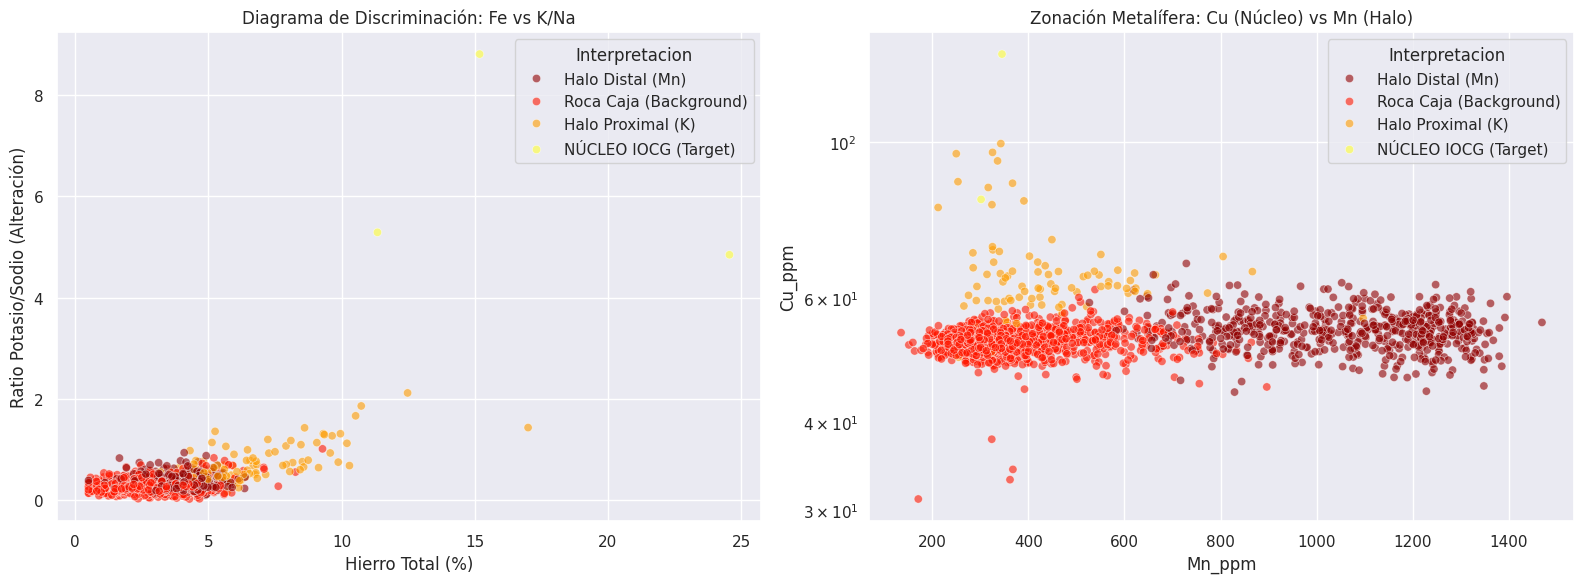

In [4]:
##_4_VALIDACIÓN GEOQUÍMICA

print("Validando Clusters con diagramas de alteración...")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Fe vs K/Na (El discriminante clásico IOCG)
sns.scatterplot(x='Fe_pct', y='K_Na_Ratio', hue='Interpretacion', data=df_exp, ax=ax[0], palette='hot', alpha=0.6)
ax[0].set_title('Diagrama de Discriminación: Fe vs K/Na')
ax[0].set_ylabel('Ratio Potasio/Sodio (Alteración)')
ax[0].set_xlabel('Hierro Total (%)')

# Cu vs Mn (Separación Núcleo-Halo)
sns.scatterplot(x='Mn_ppm', y='Cu_ppm', hue='Interpretacion', data=df_exp, ax=ax[1], palette='hot', alpha=0.6)
ax[1].set_title('Zonación Metalífera: Cu (Núcleo) vs Mn (Halo)')
ax[1].set_yscale('log') # Logarítmico porque el Cu varía mucho

plt.tight_layout()
plt.show()